# Upgrad Skin Cancer Detection Assignment using CNN

***Note***: Please note that I used **Pytorch** for the assignment rather Tensorflow

**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Install required Python Libraries

In [1]:
!pip install -q gdown Augmentor scikit-image patool torchinfo matplotlib numpy pandas IPython torch torchvision

### Importing all the important libraries

In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import json
import time
from IPython.display import display, clear_output
from skimage import io, transform

import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.transforms as T
from torchinfo import summary
from torch import flatten
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline

## Download Images from Google drive

In [3]:
import gdown

file_id = "1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs"
output_file = "CNN_assignment.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From (original): https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs
From (redirected): https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs&confirm=t&uuid=3b7d04b3-f680-475d-b678-784e1f2a9d49
To: /kaggle/working/CNN_assignment.zip
100%|██████████| 824M/824M [00:06<00:00, 119MB/s]  


'CNN_assignment.zip'

In [4]:
!rm -rf 'Skin cancer ISIC The International Skin Imaging Collaboration'

### Unzip images to local directory

In [5]:
import patoolib
patoolib.extract_archive("CNN_assignment.zip",outdir=".")

INFO patool: Extracting CNN_assignment.zip ...
INFO patool: running /usr/bin/7z x -o. -- CNN_assignment.zip
INFO patool:     with input=''
INFO patool: ... CNN_assignment.zip extracted to `.'.


'.'

In [6]:
LABELS = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

### Custom dataset to load images and labels

In [7]:
class CustomDataset(Dataset):
  def __init__(self, root, dirs=None, transform=None):

    self.root_dir = root
    self.sel_dirs = dirs
    self.transform = transform

    self.images = []
    self.labels = []
    self.__initItem()

  def __len__(self):
    if self.sel_dirs == None:
      return 0

    if len(self.images) == len(self.labels):
      return len(self.images)
    else:
      return 0

  def getImagesLabels(self):
    for (image, label) in zip(self.images, self.labels):
      print(f'{image} - {label}')

  def __initItem(self):
        
    if self.sel_dirs == None:
      print(f'No selected directories')
      self.status = False
      return

    dirPath = os.path.join(self.root_dir, self.sel_dirs)
    print('Path: ' + dirPath)

    if not os.path.isdir(dirPath):
      print(f'Data which is not a folder found into selected directories')
      self.status = False
      return
    
    for label in LABELS:
        label_dir = os.path.join(dirPath, label)
        for f in os.listdir(label_dir):
            file_with_path = os.path.join(label_dir, f)
            if os.path.isfile(file_with_path):
                self.images.append(file_with_path)
                self.labels.append(label)

        # If there is 'output' folder, capture those images also
        label_output_dir = os.path.join(dirPath, label, 'output')
        if os.path.isdir(label_output_dir):
            for f in os.listdir(label_output_dir):
                file_with_path = os.path.join(label_output_dir, f)
                if os.path.isfile(file_with_path):
                    self.images.append(file_with_path)
                    self.labels.append(label)

    print('Found ' + str(len(self.images)) + ' images')

  def __getitem__(self, index):
    image = io.imread(self.images[index])
    label = torch.tensor(int(LABELS.index(self.labels[index])))

    if self.transform:
      image = self.transform(image)

    return (image, label)

In [8]:
image_size = 64
num_classes = 9
num_epochs = 20
batch_size = 128
learning_rate = 1e-3
random_seed=42
valid_size=0.1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Transform images, prepare training, validation & test datasets

In [9]:
def load_datasets():
    normalize = T.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010])

    transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((image_size,image_size)),
                              T.ToTensor(),
                              normalize
                            ])

    training_dataset = CustomDataset(root="Skin cancer ISIC The International Skin Imaging Collaboration",
                              dirs="Train", transform=transforms)

    test_dataset = CustomDataset(root="Skin cancer ISIC The International Skin Imaging Collaboration",
                              dirs="Test", transform=transforms)
    
    return training_dataset, test_dataset

In [10]:
def plot_classes_barchart(dataset):
    import seaborn as sns
    from collections import Counter

    fig, ax = plt.subplots(figsize=(12, 6))
    my_df = pd.DataFrame(Counter(dataset.labels).items())
    ax = sns.barplot(x=0, y=1, data=my_df)
    ax.set(xlabel = 'Cancer Type', ylabel='', title='Class Balance')
    ax.tick_params(axis='x', labelrotation=45)
    plt.show()

In [11]:
def prepare_data_loaders():
    num_train = len(training_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    np.random.seed(random_seed)
    np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
            training_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
            training_dataset, batch_size=batch_size, sampler=valid_sampler)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, valid_loader, test_loader

### Show sample images

In [12]:
def plot_images(data_loader):
    how_many_to_plot = 9

    batch = next(iter(train_loader))


    plt.figure(figsize=(50,50))
    for i, batch in enumerate(data_loader, start=1):
        image, label = batch
        plt.subplot(10, 10, i)
        plt.imshow(image[0, :].permute(2, 1, 0))
        plt.axis('off')
        plt.title(LABELS[label[0].item()], fontsize=28)
        if (i >= how_many_to_plot):
            break

    plt.show()

### Custom CNN model based on ResNet9 architecture

#### Evaluated with Custom AlexNet & VGG16 based architectures, but ResNet9 based architecture is better working.

In [13]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class CustomResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

### Training & validation model routine

In [14]:
def train(train_loader, valid_loader, model):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)

    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_total_step = len(train_loader)
    valid_total_step = len(valid_loader)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        train_loss, train_correct, train_total = 0, 0, 0
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            train_correct += correct
            train_total += labels.size(0)

            #print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{train_total_step}], Acc: {correct}, Loss: {loss.item():.4f}')

        print(f'Epoch [{epoch+1}/{num_epochs}] - Training loss: {train_loss/train_total_step:.4f}, Training accuracy ({train_total} training images): {100 * train_correct/train_total:.2f}%')
        res['train_loss'].append(train_loss/train_total_step)
        res['train_acc'].append(100 * train_correct/train_total)


        # Validation
        with torch.no_grad():
            val_correct, val_loss, val_total = 0, 0, 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                del images, labels, outputs

            print(f'Epoch [{epoch+1}/{num_epochs}] - Validation loss: {val_loss/valid_total_step:.4f}, Validation accuracy ({val_total} validation images): {100 * val_correct / val_total:.2f} %')

            res['val_loss'].append(val_loss/valid_total_step)
            res['val_acc'].append(100 * val_correct/val_total)
            
    return res

In [15]:
def test(test_loader, model):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')

### Visualizing training results

In [16]:
def plot_metrics_charts(res):
    acc = res['train_acc']
    val_acc = res['val_acc']

    loss = res['train_loss']
    val_loss = res['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Train & Validation the Custom CNN Model

Path: Skin cancer ISIC The International Skin Imaging Collaboration/Train
Found 2239 images
Path: Skin cancer ISIC The International Skin Imaging Collaboration/Test
Found 118 images


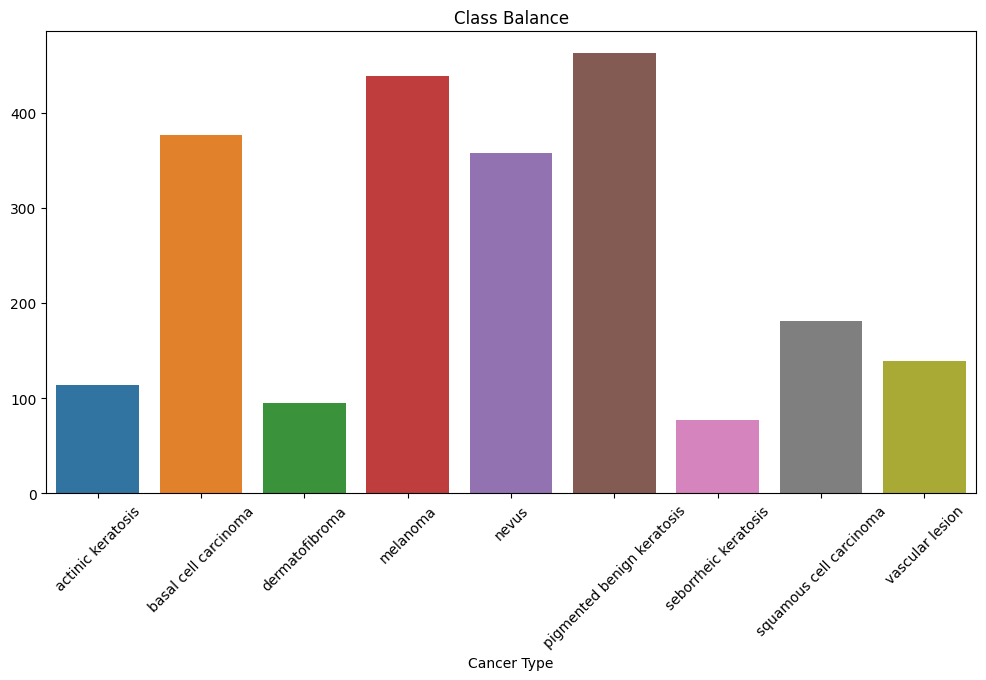

Image samples


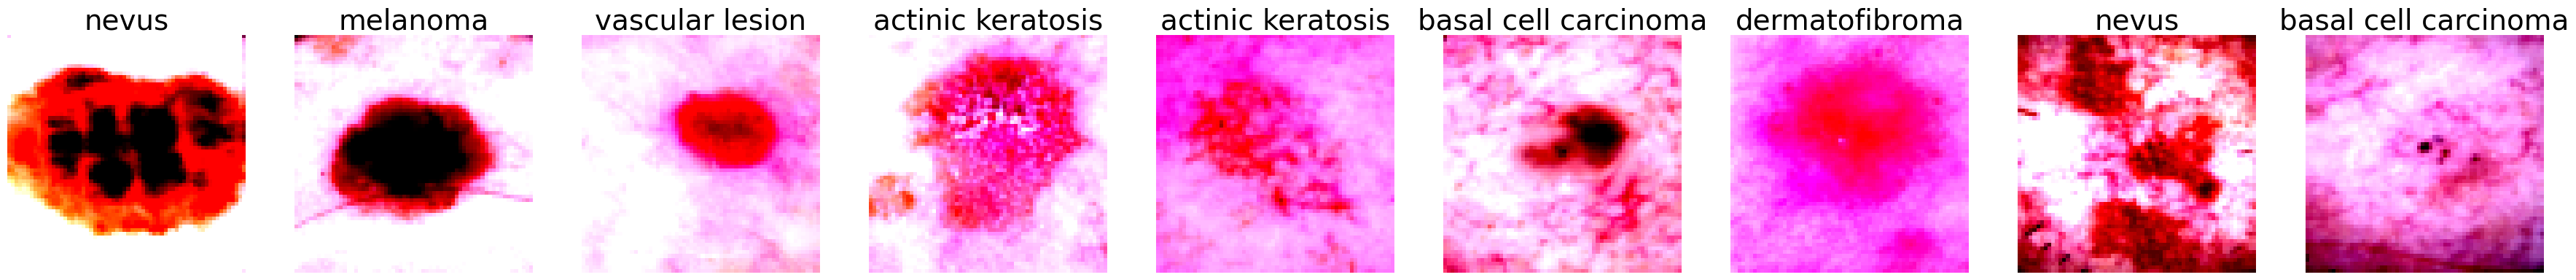

Training the model ...
Epoch [1/20] - Training loss: 2.5113, Training accuracy (2016 training images): 35.66%
Epoch [1/20] - Validation loss: 1.5937, Validation accuracy (223 validation images): 44.84 %
Epoch [2/20] - Training loss: 1.5030, Training accuracy (2016 training images): 48.61%
Epoch [2/20] - Validation loss: 1.4302, Validation accuracy (223 validation images): 47.09 %
Epoch [3/20] - Training loss: 1.3913, Training accuracy (2016 training images): 50.10%
Epoch [3/20] - Validation loss: 1.4518, Validation accuracy (223 validation images): 51.57 %
Epoch [4/20] - Training loss: 1.3469, Training accuracy (2016 training images): 51.88%
Epoch [4/20] - Validation loss: 1.3680, Validation accuracy (223 validation images): 50.67 %
Epoch [5/20] - Training loss: 1.2949, Training accuracy (2016 training images): 53.57%
Epoch [5/20] - Validation loss: 1.2695, Validation accuracy (223 validation images): 52.91 %
Epoch [6/20] - Training loss: 1.2532, Training accuracy (2016 training images

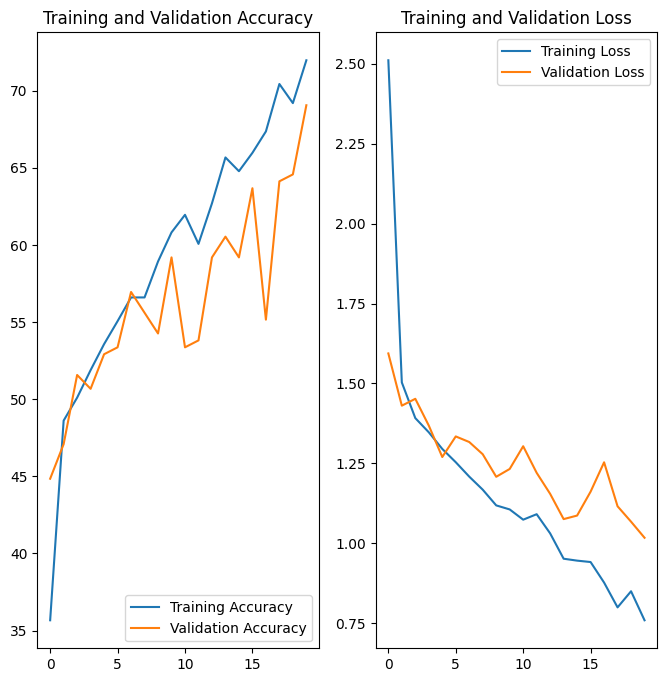

In [17]:
# Load dataset
training_dataset, test_dataset = load_datasets()
# Print classes
plot_classes_barchart(training_dataset)

# Prepare data loader
train_loader, valid_loader, test_loader = prepare_data_loaders()

# Plot sample images
print('Image samples')
plot_images(train_loader)

model = CustomResNet9(3, num_classes)
model.to(device)
summary(model, (1, 3, image_size, image_size))

# Train model
print('Training the model ...')
res = train(train_loader, valid_loader, model)

# Test model
test(test_loader, model)

# Display 
print('Metrics')
plot_metrics_charts(res)

del model

In [18]:
path_to_training_dataset= 'Skin cancer ISIC The International Skin Imaging Collaboration/Train'
path_to_test_dataset= 'Skin cancer ISIC The International Skin Imaging Collaboration/Test'

def display_image_counts():
    # Defining the path for train and test images
    ## Todo: Update the paths of the train and test dataset
    data_dir_train = pathlib.Path(path_to_training_dataset)
    data_dir_test = pathlib.Path(path_to_test_dataset)

    image_count_train = len(list(data_dir_train.glob('**/*.jpg')))
    print(f'Total training images: {image_count_train}')
    image_count_test = len(list(data_dir_test.glob('**/*.jpg')))
    print(f'Total test images: {image_count_test}')
    
    
display_image_counts()

Total training images: 2239
Total test images: 118


## Data Augmentation

In [19]:
import Augmentor
for i in LABELS:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CFA0A7C3FD0>: 100%|██████████| 500/500 [00:06<00:00, 77.66 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CF9F2915B10>: 100%|██████████| 500/500 [00:06<00:00, 81.57 Samples/s]                   


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CFA0A7CE110>: 100%|██████████| 500/500 [00:06<00:00, 77.83 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CF9E3092770>: 100%|██████████| 500/500 [00:34<00:00, 14.48 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CFA0A75C370>: 100%|██████████| 500/500 [00:35<00:00, 13.91 Samples/s]  


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CF9E3094340>: 100%|██████████| 500/500 [00:06<00:00, 78.23 Samples/s]                   


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7CFA0A94A9B0>: 100%|██████████| 500/500 [00:15<00:00, 32.38 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CF9E3092B00>: 100%|██████████| 500/500 [00:06<00:00, 79.63 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CFA0A773A00>: 100%|██████████| 500/500 [00:06<00:00, 73.06 Samples/s]                  


In [20]:
display_image_counts()

Total training images: 6739
Total test images: 118


Path: Skin cancer ISIC The International Skin Imaging Collaboration/Train
Found 6739 images
Path: Skin cancer ISIC The International Skin Imaging Collaboration/Test
Found 118 images


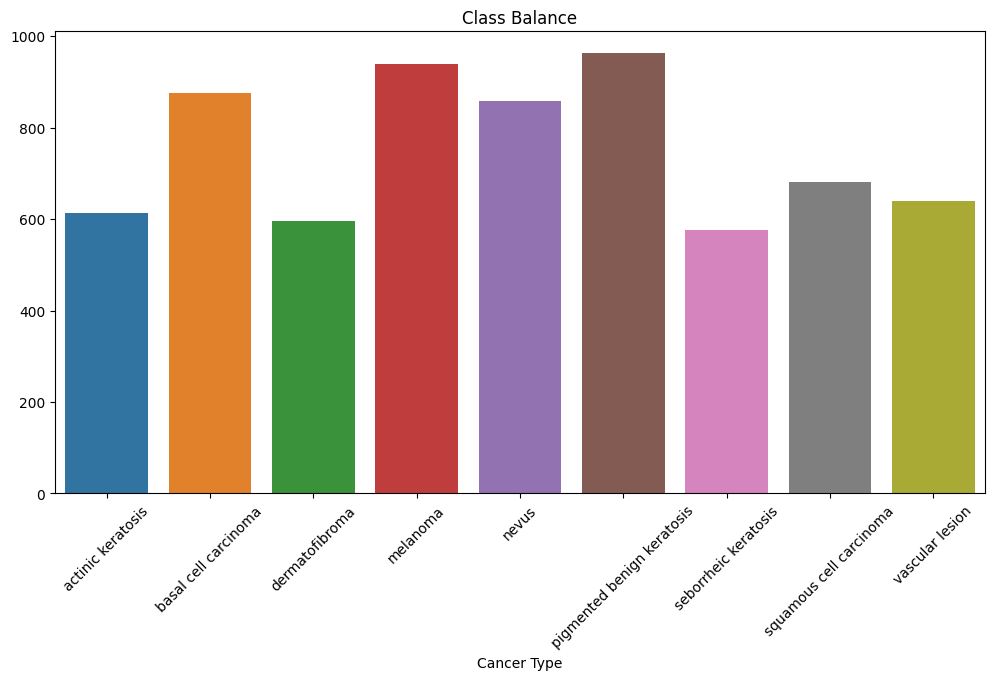

Image samples


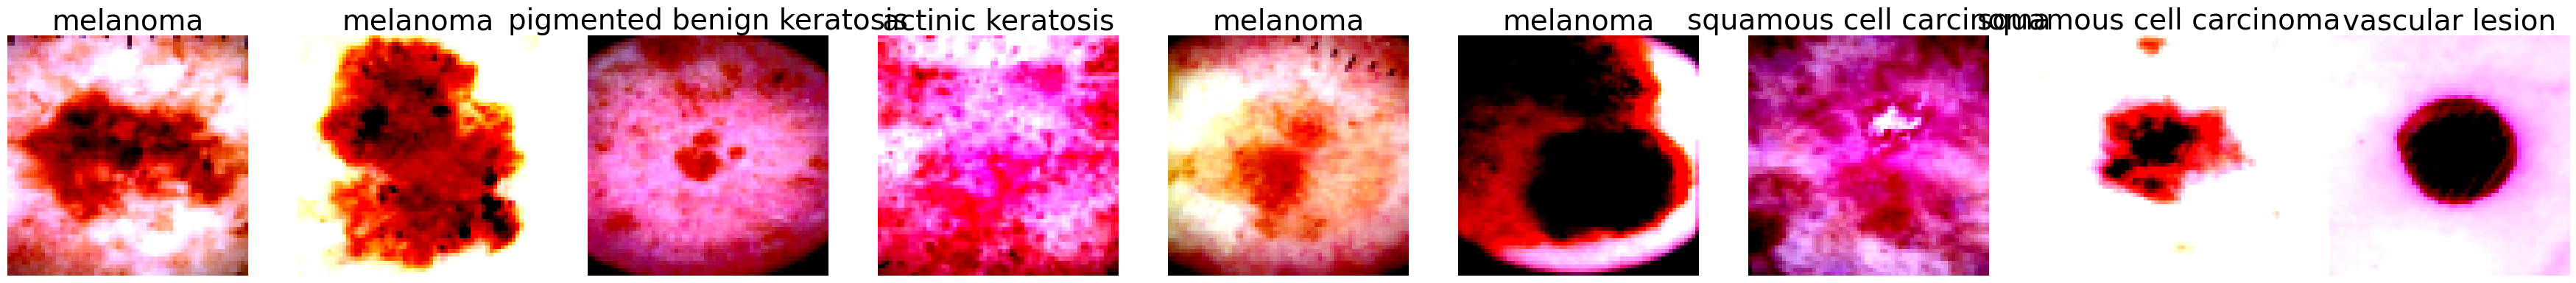

Training the model ...
Epoch [1/30] - Training loss: 1.7471, Training accuracy (6066 training images): 39.12%
Epoch [1/30] - Validation loss: 1.4398, Validation accuracy (673 validation images): 47.55 %
Epoch [2/30] - Training loss: 1.3292, Training accuracy (6066 training images): 49.90%
Epoch [2/30] - Validation loss: 1.2956, Validation accuracy (673 validation images): 52.30 %
Epoch [3/30] - Training loss: 1.2095, Training accuracy (6066 training images): 54.43%
Epoch [3/30] - Validation loss: 1.3723, Validation accuracy (673 validation images): 52.75 %
Epoch [4/30] - Training loss: 1.1268, Training accuracy (6066 training images): 57.27%
Epoch [4/30] - Validation loss: 1.2421, Validation accuracy (673 validation images): 56.61 %
Epoch [5/30] - Training loss: 0.9904, Training accuracy (6066 training images): 63.17%
Epoch [5/30] - Validation loss: 1.1402, Validation accuracy (673 validation images): 59.73 %
Epoch [6/30] - Training loss: 0.8932, Training accuracy (6066 training images

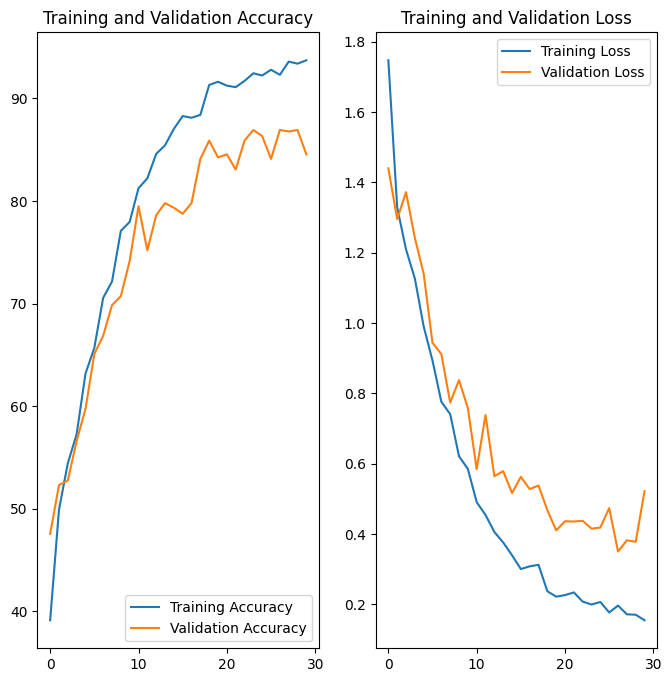

In [21]:
# Load dataset
training_dataset, test_dataset = load_datasets()
# Print classes
plot_classes_barchart(training_dataset)

# Prepare data loader
train_loader, valid_loader, test_loader = prepare_data_loaders()

# Plot sample images
print('Image samples')
plot_images(train_loader)

model = CustomResNet9(3, num_classes)
model.to(device)
summary(model, (1, 3, image_size, image_size))

num_epochs = 30 #20

# Train model
print('Training the model ...')
res = train(train_loader, valid_loader, model)

# Test model
test(test_loader, model)

# Display 
print('Metrics')
plot_metrics_charts(res)